# Data Description
The pneumonia training dataset contains 3,875 x-ray images classified as pneumonia and 1,341 x-ray images classified as normal. The pneumonia samples have been downsized to 1,341 to mitigate the class imbalance issue. All images have been resized and cropped to 300 x 224 on an Amazon Elastic Compute Cloud (EC2) P3 Xlarge instance with 64 CPUs.

# Model
I used a pre-trained resnet34 model with a batch size of 250, a maximized learning rate of 0.01, and trained the model for 2 epochs.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

Using matplotlib backend: <object object at 0x7dc0151fb670>


In [2]:
import cv2
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [ ]:
#from google.colab import files
#files.upload()  # Choose the kaggle.json file that you downloaded


In [ ]:
#!mkdir -p ~/.kaggle
#!cp ./kaggle-2.json ~/.kaggle/kaggle.json
#!chmod 600 ~/.kaggle/kaggle.json


In [4]:
#!ls ~/.kaggle

In [ ]:
#!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100%|█████████████████████████████████████▉| 2.29G/2.29G [00:52<00:00, 72.4MB/s]
100%|██████████████████████████████████████| 2.29G/2.29G [00:52<00:00, 47.3MB/s]


In [ ]:
#import shutil
#file_path = './chest_xray'
#file_path = './chest_xray/PNEUMONIA_downsampled'
#shutil.rmtree(file_path)

In [ ]:
#!mkdir ./data
#!cp ./chest-xray-pneumonia.zip ./data/

mkdir: ./data: File exists


In [ ]:
#! unzip -q ./chest-xray-pneumonia.zip

In [4]:
import os
current = os.getcwd()
print(current)

/content


In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
directory_path = os.path.dirname('/content/drive/MyDrive')
files = os.listdir(directory_path)
print(files)

['.file-revisions-by-id', '.shortcut-targets-by-id', 'MyDrive', '.Trash-0']


In [7]:
def read_image(path):
    im = cv2.imread(str(path))
    if im is None:
        raise IOError(f"Unable to read image file: {path}")
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

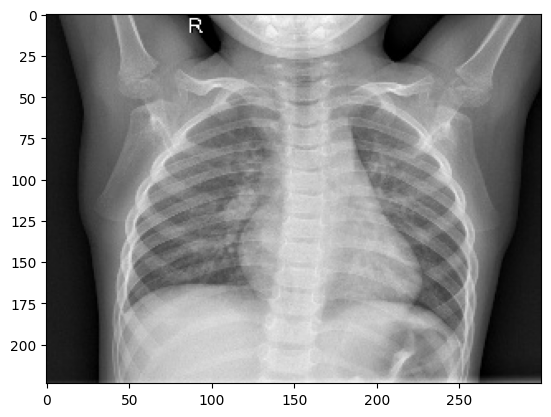

In [8]:
file_path = '/content/drive/MyDrive/train_300_224/IM-0115-0001.jpeg'
image = read_image(file_path)
plt.imshow(image)

In [9]:
from pathlib import Path
PATH = Path('/content/drive/MyDrive/train_300_224')
#list(PATH.iterdir())

In [10]:
image = cv2.imread(str(file_path))
image.shape

(224, 300, 3)

In [12]:
path = PATH/"train/PNEUMONIA"
files = list(path.iterdir())

In [ ]:
len(files)

In [ ]:
path = PATH/"train/NORMAL"
files = list(path.iterdir())
len(files)

In [ ]:
1341 / (3875 + 1341)

0.2570935582822086

Imbalanced Dataset. the total pneumonia images (class = 1) = 3875 and the total normal images (class = 0) = 1341. only 25% of the training data is normal images. we will need to downsample the pneumonia data size for a better training result.

In [ ]:
pneumonia_list = [image for image in (PATH/'train/PNEUMONIA').iterdir() if 'PNEUMONIA' in str(image)]
normal_list = [image for image in (PATH/'train/NORMAL').iterdir() if 'NORMAL' in str(image)]

In [ ]:
len(pneumonia_list)

3875

In [ ]:
#!ls ./chest_xray/PNEUMONIA_downsampled

In [ ]:
#from sklearn.utils import resample
#pneumonia_downsampled = resample(pneumonia_list, replace = False, n_samples = 1341, random_state = 43)

In [ ]:
len(pneumonia_downsampled)

1341

In [ ]:
#normal_downsampled = resample(normal_list, replace = False, n_samples = 1341, random_state = 43)

In [ ]:
#len(normal_downsampled)

1341

In [ ]:
import shutil
target_directory = PATH/"PNEUMONIA_downsampled"
#target_directory.mkdir(parents = True, exist_ok = True)

#for file_path in pneumonia_downsampled:
 #   shutil.copy(file_path, target_directory)

In [ ]:
#target_directory = PATH/"normal_downsampled"
#target_directory.mkdir(parents = True, exist_ok = True)

#for file_path in normal_downsampled:
 # shutil.copy(file_path, target_directory)

In [ ]:
PATH = Path('./chest_xray/PNEUMONIA_downsampled')
list(PATH.iterdir())[:3]

[PosixPath('chest_xray/PNEUMONIA_downsampled/person63_bacteria_306.jpeg'),
 PosixPath('chest_xray/PNEUMONIA_downsampled/person276_bacteria_1296.jpeg'),
 PosixPath('chest_xray/PNEUMONIA_downsampled/person1353_virus_2333.jpeg')]

In [ ]:
files = list(PATH.iterdir())[:5]
dims = [read_image(str(p)).shape for p in files]
np.unique(dims)

array([   3,  584,  736,  944, 1024, 1040, 1048, 1256, 1336, 1400, 1408])

In [ ]:
PATH = Path('./chest_xray')
path = PATH/"NORMAL_downsampled"
files = list(path.iterdir())[:3]
files

[PosixPath('chest_xray/NORMAL_downsampled/NORMAL2-IM-0927-0001.jpeg'),
 PosixPath('chest_xray/NORMAL_downsampled/NORMAL2-IM-1056-0001.jpeg'),
 PosixPath('chest_xray/NORMAL_downsampled/IM-0427-0001.jpeg')]

In [ ]:
files[:5][-1]

PosixPath('chest_xray/NORMAL_downsampled/IM-0427-0001.jpeg')

In [ ]:
path = PATH/"test/NORMAL"
files = list(path.iterdir())
len(files)

234

In [ ]:
390+234

624

#Data Augmentation
Data Augmentation is the most important way to avoid overfitting for image classification tasks.

In [ ]:
desired_width = 300
desired_height = 224

def resized_all_images(resize_path, pneumonia_path):
  pneumonia_files = list(pneumonia_path.iterdir())
  normal_files = list(normal_path.iterdir())
#  (resize_path/'train_300_224_pneu').mkdir(parents= True, exist_ok= True)
  # read and resize each image
  resized_images = []
  for file in pneumonia_files:
    image = cv2.imread(str(file))
    f_name = file.parts[-1]
    new_path = resize_path/f_name
    if image is not None:
      resized_image = cv2.resize(image, (desired_width, desired_height))
      resized_images.append(resized_image)
      cv2.imwrite(str(resize_path/'train_300_224_pneu'/f_name), cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR))
    else:
      print(f"Unable to read image: {file}")


In [ ]:
# Define the paths to the pneumonia and normal image directories
pneumonia_path = PATH/"PNEUMONIA_downsampled"

# Specify the resize path where the resized images will be saved
resize_path = PATH/'train_300_224_p'

In [ ]:
#resized_all_images(resize_path, pneumonia_path)

In [ ]:
desired_width = 300
desired_height = 224

def resized_all_images(resize_path, normal_path):
  pneumonia_files = list(pneumonia_path.iterdir())
  normal_files = list(normal_path.iterdir())
#  (resize_path/'train_300_224_normal').mkdir(parents= True, exist_ok= True)
  # read and resize each image
  resized_images = []

  for file in normal_files:
    image = cv2.imread(str(file))
    f_name = file.parts[-1]
    new_path = resize_path/f_name
    if image is not None:
      resized_image = cv2.resize(image, (desired_width, desired_height))
      resized_images.append(resized_image)
      cv2.imwrite(str(resize_path/'train_300_224_normal'/f_name), cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR))
    else:
      print(f"Unable to read image: {file}")

In [ ]:
# Define the paths to the pneumonia and normal image directories
normal_path = PATH/'NORMAL_downsampled'

# Specify the resize path where the resized images will be saved
resize_path = PATH/'train_300_224_n'

In [ ]:
#resized_all_images(resize_path, normal_path)

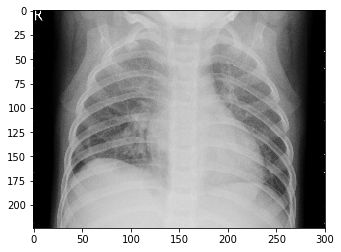

In [ ]:
file_path = './chest_xray/train_300_224_p/train_300_224_pneu/person1848_bacteria_4719.jpeg'
image = read_image(file_path)
plt.imshow(image)

In [ ]:
desired_width = 300
desired_height = 224

def resized_all_test_images(resize_path, pneumonia_path, normal_path):
  pneumonia_files = list(pneumonia_path.iterdir())
  normal_files = list(normal_path.iterdir())
  (resize_path/'valid_300_224').mkdir(parents= True, exist_ok= True)
  # read and resize each image
  resized_images = []
  for file in pneumonia_files:
    image = cv2.imread(str(file))
    f_name = file.parts[-1]
    new_path = resize_path/f_name
    if image is not None:
      resized_image = cv2.resize(image, (desired_width, desired_height))
      resized_images.append(resized_image)
      cv2.imwrite(str(resize_path/'valid_300_224'/f_name), cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR))
    else:
      print(f"Unable to read image: {file}")

    for file in normal_files:
      image = cv2.imread(str(file))
      f_name = file.parts[-1]
      new_path = resize_path/f_name
      if image is not None:
        resized_image = cv2.resize(image, (desired_width, desired_height))
        resized_images.append(resized_image)
        cv2.imwrite(str(resize_path/'valid_300_224'/f_name), cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR))
      else:
        print(f"Unable to read image: {file}")

In [ ]:
!ls ./chest_xray/

PNEUMONIA_downsampled normal_downsampled    train_300_224_n
__MACOSX              test                  train_300_224_p
chest_xray            train                 val


In [ ]:
# Define the paths to the pneumonia and normal image directories
pneumonia_path = PATH/'test/PNEUMONIA'
normal_path = PATH/'test/NORMAL'

# Specify the resize path where the resized images will be saved
resize_path = PATH/'valid_300_224'

#resized_all_test_images(resize_path, pneumonia_path, normal_path)

In [13]:
def rotate_cv(im, deg, mode = cv2.BORDER_REFLECT, interpolation= cv2.INTER_AREA):
  '''Rotates an image by deg degrees'''
  r, c, *_ = im.shape #row, column
  M = cv2.getRotationMatrix2D((c/2, r/2), deg, 1)
  return cv2.warpAffine(im, M, (c, r), borderMode= mode,
                        flags = cv2.WARP_FILL_OUTLIERS+ interpolation)

In [15]:
def adjust_brightness(image, alpha = 1.0, beta = 0.0):
    adjusted_image = cv2.convertScaleAbs(image, alpha = alpha, beta = beta)
    return adjusted_image

# Dataset

In [14]:
def normalize(im):
  '''Normalizes images with Imagenet Stats.'''
  imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
  return (im - imagenet_stats[0] / imagenet_stats[1])

In [16]:
directory_path = Path('/content/drive/MyDrive/valid_300_224')

In [17]:
labels_1 = [1 for image in directory_path.iterdir() if 'person' in str(image)]
labels_0 = [0 for image in directory_path.iterdir() if 'IM' in str(image)]
labels = np.concatenate([labels_1, labels_0], axis =0)

In [18]:
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [19]:
class PneumoniaDataset(Dataset):
  def __init__(self, file_path, transform = False):
    self.file_path = file_path
    self.labels_1 = [1 for image in self.file_path.iterdir() if 'person' in str(image)]
    self.labels_0 = [0 for image in self.file_path.iterdir() if 'IM' in str(image)]
    self.labels = np.concatenate([self.labels_1, self.labels_0], axis = 0)
    self.transform = transform

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, index):
    y = self.labels[index]
    #file_name = self.file_path.parts[-1]
    file_name = list(self.file_path.iterdir())[index].name
    path = self.file_path/file_name
    x = read_image(path)
    if self.transform:
        rdeg = (np.random.random() -0.50)*20
        x = rotate_cv(x, rdeg)
        x = cv2.convertScaleAbs(x, alpha = 1.5, beta = 50)
        if np.random.random() > 0.5:
            x= np.fliplr(x).copy()
    else:
        x = x
        x = normalize(x)
    return np.rollaxis(x, 2, 0), y[None]

In [20]:
file_path = Path('/content/drive/MyDrive/')
train_ds = PneumoniaDataset(file_path/'train_300_224', transform = True)
valid_ds = PneumoniaDataset(file_path/'valid_300_224', transform = False)

In [21]:
len(train_ds), len(valid_ds)

(2432, 624)

In [22]:
x, y = train_ds[0]
x.shape, y

((3, 224, 300), array([1]))

In [23]:
train_loader = DataLoader(train_ds, batch_size = 64, shuffle = True, num_workers = 2)
valid_loader = DataLoader(valid_ds, batch_size = 64, num_workers = 2)

In [24]:
len(train_ds)

2432

In [25]:
batch_size = 250
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
valid_dl = DataLoader(valid_ds, batch_size = batch_size)

In [26]:
x, y = train_ds[0]
x.shape

(3, 224, 300)

In [38]:
np.rollaxis(x, 0, 3).shape

(224, 300, 3)

In [27]:
#transforming back to the original image
imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
im = np.rollaxis(x, 0, 3)
im = im* imagenet_stats[1] + imagenet_stats[0]
im = im.astype(int)

#Model

In [28]:
resnet = models.resnet34(weights= 'DEFAULT').cuda()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 207MB/s]


In [29]:
layers = list(resnet.children())
print(len(layers))
layers[-2:]

10


[AdaptiveAvgPool2d(output_size=(1, 1)),
 Linear(in_features=512, out_features=1000, bias=True)]

In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(weights= 'IMAGENET1K_V1')
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512,1), nn.Dropout(0.5))

    def forward(self, x):
        x= self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().cuda()

In [28]:
x, y = next(iter(train_dl))

In [30]:
x = x.cuda()
y = y.cuda()
x.shape

torch.Size([1000, 3, 224, 300])

In [31]:
x = x.to(device).float()
y = y.to(device).float()

In [32]:
x_features = model.features1(x)
x_features.shape

torch.Size([1000, 128, 28, 38])

In [41]:
x_features2 = model.features2(x_features)
x_features2.shape

In [ ]:
x_features2 = F.relu(x_features2)

In [ ]:
x_features_ave = nn.AdaptiveAvgPool2d((1, 1))(x_features2)
x_features_ave.shape

In [ ]:
x_features_flatten = x_features_ave.view(x_features_ave.shape[0], -1)
x_features_flatten.shape

In [ ]:
y_hat = model(x).cuda()
y_hat.shape

In [ ]:
F.binary_cross_entropy_with_logits(y_hat, y)

In [ ]:
y.shape

In [31]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1+ np.cos(i * np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 * c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr / 25, max_lr / (25*1e4)
    iter1 = int(0.3 * iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr,iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

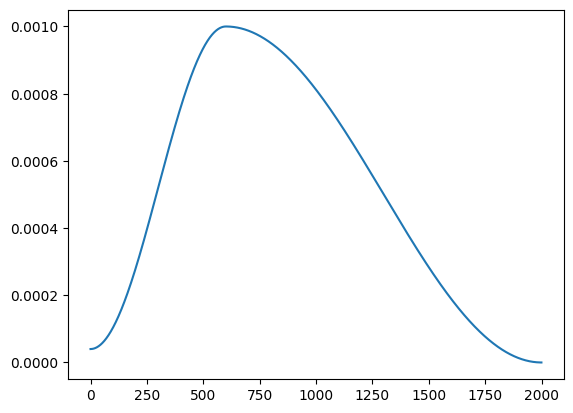

In [32]:
N = 2000
lr = get_cosine_triangular_lr(0.001, N)
plt.plot(list(range(N)), lr)
plt.show()

In [33]:
def create_optimizer(model, lr0):
    params = [{'params': model.features1.parameters(), 'lr': lr0/9},
              {'params': model.features2.parameters(), 'lr': lr0/3},
              {'params': model.classifier.parameters(), 'lr': lr0}]
    return optim.Adam(params, weight_decay = 1e-5)

def update_optimizer(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
            param_group['lr'] = group_lrs[i]


In [34]:
def save_model(m, p): torch.save(m.state_dict(), p)

In [35]:
def train_one_epoch(model, optimizer, train_dl, lrs, idx):
    model.train()
    total = 0
    sum_loss = 0
    for x, y in train_dl:
        lr = lrs[idx]
        update_optimizer(optimizer, [lr/9, lr/3, lr])
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda().float()
        out = model(x)
        loss = F.binary_cross_entropy_with_logits(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        idx +=1
        total += batch
        sum_loss += batch *(loss.item())
    return sum_loss/total, idx

In [36]:
def train_triangular_policy(model, train_dl, valid_dl, max_lr = 0.04, epochs= 5):
    idx = 0
    iterations = epochs * len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_loss = 10000.0
    for i in range(epochs):
        train_loss, idx = train_one_epoch(model, optimizer, train_dl, lrs, idx)
        val_loss, val_acc = val_metrics(model, valid_dl, device)
        print('train_loss %.3f val_loss %.3f val_acc %.3f' % (train_loss, val_loss, val_acc))
        if val_loss < prev_val_loss:
            prev_val_loss = val_loss
            path = '{0}/models/model_resnet34_{1:.0f}.pth'.format(PATH, 100* val_acc)
            save_model(model, path)
            print(path)

In [68]:
def val_metrics(model, valid_dl, device):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0

    with torch.no_grad():
        for x, y in valid_dl:
            batch = y.shape[0]
            x = x.to(device).float()
            y = y.to(device).float()
            out = model(x)
            pred = (out> 0.0).float()
            correct += pred.eq(y.float()).sum().item()
            y = y.float()
            loss = F.binary_cross_entropy_with_logits(out, y)
            sum_loss += batch *(loss.item())
            total += batch

        return sum_loss/total, correct/total

In [67]:
#free up memory
torch.cuda.empty_cache()


In [75]:
val_metrics(model, valid_dl, device)

(1.1153090660675213, 0.5064102564102564)

In [70]:
PATH = Path('/content/drive/MyDrive/')

In [72]:
(PATH/'models').mkdir(parents = True, exist_ok = True)

In [73]:
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr = 0.01, epochs = 2)

train_loss 1.009 val_loss 1019.673 val_acc 0.375
/content/drive/MyDrive/models/model_resnet34_38.pth
train_loss 0.628 val_loss 9.236 val_acc 0.623
/content/drive/MyDrive/models/model_resnet34_62.pth


# Model Evaluation

High Recall (0.963): The model is very effective at identifying actual positives, which is crucial in classifying pneumonia where missing a positive instance (false negative) is costly.

Model Weaknesses:

Moderate Precision (0.629): The model has a moderate rate of false positives, meaning it sometimes incorrectly predicts negative instances as positive.
Moderate Accuracy (0.623): Overall, the model correctly classifies a little over 62% of instances, indicating that there is significant room for improvement.
High Loss: The high validation loss (0.97) suggests that the model's predictions are not very close to the actual values, indicating potential issues in model fitting or data representation.

In [62]:
from sklearn.metrics import precision_score, recall_score

In [65]:
def val_metrics(model, valid_dl, device):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for x, y in valid_dl:
            batch = y.shape[0]
            x = x.to(device).float()
            y = y.to(device).float()
            out = model(x)
            pred = (out> 0.0).float()
            correct += pred.eq(y.float()).sum().item()
            y = y.float()
            loss = F.binary_cross_entropy_with_logits(out, y)
            sum_loss += batch *(loss.item())
            total += batch

            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(y.cpu().numpy())
    avg_loss = sum_loss/total
    accuracy = correct / total

    precision = precision_score(all_targets, all_preds)
    recall = recall_score(all_targets, all_preds)

    return avg_loss, accuracy, precision, recall

In [66]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

val_loss, val_accuracy, val_precision, val_recall = val_metrics(model, valid_dl, device)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")

Validation Loss: 0.9789527836136329
Validation Accuracy: 0.6233974358974359
Validation Precision: 0.6298157453936348
Validation Recall: 0.9641025641025641
